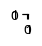

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_metrics
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.bootstrap import get_pval, plot_pval
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# small dim tests

In [76]:
in_dim=21*23
hidden_dim=128
n_layers=2

layers = [nn.Linear(in_dim, in_dim//2), nn.ReLU()]
for n in range(n_layers-1):
    in_dim=in_dim//2
    layers.extend([nn.Linear(in_dim, in_dim//2), nn.ReLU()])
print(layers)

[Linear(in_features=483, out_features=241, bias=True), ReLU(), Linear(in_features=241, out_features=120, bias=True), ReLU()]


# Gliph first because it's shorter

In [29]:
# These are Mtb specific TCRs
gliph_bulk = pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'bulk TCR')
gliph_sc =  pd.read_excel('../data/GLIPH/GLIPH2_Mtb_TCRs_41587_2020_505_MOESM3_ESM.xlsx', sheet_name = 'single cell TCR')
gliph_sc.drop(columns=[x for x in gliph_sc.columns if 'Unnamed' in x and not '40' in x], inplace=True)

gliph_bulk['len_beta'] = gliph_bulk['CDR3b'].apply(len)
gliph_sc['len_beta'] = gliph_sc['CDR3beta'].apply(lambda x: len(x) if x is not np.nan else np.nan)
gliph_sc['len_alpha'] = gliph_sc['CDR3alpha'].apply(lambda x: len(x) if x is not np.nan else np.nan)

In [172]:
# 3264 TCRs in the GLIPH VDJdb
gliph_vdjdb = pd.read_excel('../data/GLIPH/GLIPH2_VDJdb_41587_2020_505_MOESM4_ESM.xlsx', header=None, names=['CDR3b', 'V', 'J', 'peptide'])
display(gliph_vdjdb.head()), print(len(gliph_vdjdb))

,CDR3b,V,J,peptide
0,CASTGSYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
1,CASSLTYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
2,CASSSRTGGYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF
3,CATSDRMDNEQFF,TRBV24-1*01,TRBJ2-1*01,KAFSPEVIPMF
4,CASGGEFYGYTF,TRBV7-9*01,TRBJ1-2*01,KAFSPEVIPMF


3264


(None, None)

In [32]:
print(len(gliph_bulk))
display(gliph_bulk.head())

10501


,CDR3b,Vb,Jb,CDR3a,Va,Ja,Individual,Counts,len_beta
0,CASRDRGLSYEQYF,TRBV10-3,NaN,NaN,NaN,NaN,01/1016,1,14
1,CASRLGLAGLTQETQYF,TRBV5-1,NaN,NaN,NaN,NaN,01/1016,3,17
2,CASRPGLWGEQFF,TRBV28,NaN,NaN,NaN,NaN,01/1016,2,13
3,CASRQAGRDEQFF,TRBV6-1,NaN,NaN,NaN,NaN,01/1016,1,13
4,CASRSRGGRTYNEQFF,TRBV6-2,NaN,NaN,NaN,NaN,01/1016,2,16


In [33]:
print(len(gliph_sc))
display(gliph_sc.head())

8255


,Individual,Stim,Vbeta,Jbeta,CDR3beta,BetaConfi,BetaReads,Valpha,Jalpha,CDR3alpha,AlphaConfi,AlphaReads,2ndValpha,2ndJalpha,CDR3alpha2nd,Confi,Reads,Unnamed: 40,len_beta,len_alpha
0,01/1013,MtbLys,TRBV28,TRBJ2-7,CASMGQIYEQYF,0.928,5434.0,TRAV9-1,TRAJ57,CALSAQGGSEKLVF,0.924,4636.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGGGTACAGTGTCTCTAGAGAG...,12.0,14.0
1,01/1013,MtbLys,TRBV5-1,TRBJ1-3,CASSLESVSGNTIYF,0.932,4931.0,TRAV26-1,TRAJ56,CIVRVSGAGANSKLTF,0.619,2358.0,TRAV26-2,TRAJ43,NaN,0.273,1041.0,GCCCAGGGTTTTCCCAGTCACGACCGATTCTCAGGGCGCCAGTTCT...,15.0,16.0
2,01/1013,MtbLys,TRBV19,TRBJ1-6,CASKRDSQAYNSPLHF,0.928,4841.0,TRAV8-3,TRAJ27,CAANTNAGKSTF,0.910,5573.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGTACAGCGTCTCTCGGGAGAA...,16.0,12.0
3,01/1013,MtbLys,TRBV6-1,TRBJ2-7,CASSALQAYEQYF,0.925,5296.0,TRAV17,TRAJ52,NaN,0.996,3589.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACTGGCTACAATGTCTCCAGATTA...,13.0,NaN
4,01/1013,MtbLys,TRBV20-1,TRBJ2-3,CSARSPPDTQYF,0.941,5606.0,TRAV9-1,TRAJ39,CALSDRYNNAGNMLTF,0.896,3608.0,NaN,NaN,NaN,NaN,NaN,GCCCAGGGTTTTCCCAGTCACGACGGACAAGTTTCTCATCAACCAT...,12.0,16.0


In [34]:
gliph_bulk['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_bulk)+1)]
gliph_sc['seq_id'] = [f'seq_{i:05}' for i in range(1, len(gliph_sc)+1)]
gliph_bulk.to_csv('../data/GLIPH/230918_gliph_bulk.csv', index=False)
gliph_sc.to_csv('../data/GLIPH/230918_gliph_sc.csv', index=False)

In [72]:
gliph_merged_cdr3=pd.concat([gliph_bulk.assign(db='bulk').drop(columns=['Jb', 'CDR3a', 'Va', 'Ja']).rename(columns={'CDR3b':'CDR3beta', 'Vb':'Vbeta'}), 
           gliph_sc.assign(db='sc').drop(columns=[x for x in gliph_sc.columns if 'alpha' in x.lower()])]).dropna(subset='CDR3beta').reset_index(drop=True)
display(gliph_merged_cdr3.head()), print(len(gliph_merged_cdr3))

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


16663


(None, None)

In [73]:
gliph_merged_cdr3['flag'] = gliph_merged_cdr3['CDR3beta'].apply(lambda x: 'X' in x or '-' in x)
gliph_merged_cdr3.query('flag')
# Only keep the datapoints that don't have X
gliph_merged_cdr3.query('not flag').drop(columns='flag').reset_index(drop=True).to_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv', index=False)

In [158]:
gliph_merged_cdr3 = pd.read_csv('../data/GLIPH/230918_gliph_merged_cdr3beta.csv')
len(gliph_merged_cdr3), len(gliph_merged_cdr3['CDR3beta'].unique())

(16652, 15048)

In [159]:
gliph_merged_cdr3

,CDR3beta,Vbeta,Individual,Counts,len_beta,seq_id,db,Stim,Jbeta,BetaConfi,BetaReads,Confi,Reads,Unnamed: 40
0,CASRDRGLSYEQYF,TRBV10-3,01/1016,1.0,14.0,seq_00001,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CASRLGLAGLTQETQYF,TRBV5-1,01/1016,3.0,17.0,seq_00002,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CASRPGLWGEQFF,TRBV28,01/1016,2.0,13.0,seq_00003,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CASRQAGRDEQFF,TRBV6-1,01/1016,1.0,13.0,seq_00004,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CASRSRGGRTYNEQFF,TRBV6-2,01/1016,2.0,16.0,seq_00005,bulk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16647,CASSELEADTQYF,TRBV2,09/0334,NaN,13.0,seq_08249,sc,MtbLys,TRBJ2-3,0.934,7306.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGCCTGATGGATCAAATTTCACT...
16648,CSVVEGFGSFEKRNTQYF,TRBV29-1,09/0334,NaN,18.0,seq_08250,sc,MtbLys,TRBJ2-3,0.904,5390.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACGTTTCCCATCAGCCGCCCAAAC...
16649,CASSSSPGSNSPLHF,TRBV9,09/0334,NaN,15.0,seq_08251,sc,MtbLys,TRBJ1-6,0.925,6794.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACCTCCGCACAACAGTTCCCTGAC...
16650,CASSPGQPGGYTF,TRBV27,09/0334,NaN,13.0,seq_08252,sc,MtbLys,TRBJ1-2,0.937,7678.0,NaN,NaN,CTCCAGGGTTTTCCCAGTCACGACTACAAAGTCTCTCGAAAAGAGA...


# DeepTCR

In [27]:
%ls ../data/DeepTCR/


10x_Data/             Human_Antigens/       Sidhom/
Dash_Human/           Human_HLA_Tutorial/   VDJ.tsv
Dash_Murine/          McPAS-TCR.csv         Zhang/
Glanville/            Murine_Antigens/      combine_vdj_mcpas.py
HIV/                  Rudqvist/             vdj_mcpas.csv


In [160]:
tenx = pd.read_csv('../data/DeepTCR/10x_Data/Data_Regression.csv')
display(tenx.head())
print(len(tenx))

,alpha,beta,A0101_VTEHDTLLY_IE-1_CMV,A0201_KTWGQYWQV_gp100_Cancer,A0201_ELAGIGILTV_MART-1_Cancer,A0201_CLLWSFQTSA_Tyrosinase_Cancer,A0201_IMDQVPFSV_gp100_Cancer,A0201_SLLMWITQV_NY-ESO-1_Cancer,A0201_KVAELVHFL_MAGE-A3_Cancer,A0201_KVLEYVIKV_MAGE-A1_Cancer,A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase,A0201_LLDFVRFMGV_EBNA-3B_EBV,A0201_LLMGTLGIVC_HPV-16E7_82-91,A0201_CLGGLLTMV_LMP-2A_EBV,A0201_YLLEMLWRL_LMP1_EBV,A0201_FLYALALLL_LMP2A_EBV,A0201_GILGFVFTL_Flu-MP_Influenza,A0201_GLCTLVAML_BMLF1_EBV,A0201_NLVPMVATV_pp65_CMV,A0201_ILKEPVHGV_RT_HIV,A0201_FLASKIGRLV_Ca2-indepen-Plip-A2,A2402_CYTWNQMNL_WT1-(235-243)236M_Y,A0201_RTLNAWVKV_Gag-protein_HIV,A0201_KLQCVDLHV_PSA146-154,A0201_LLFGYPVYV_HTLV-1,A0201_SLFNTVATL_Gag-protein_HIV,A0201_SLYNTVATLY_Gag-protein_HIV,A0201_SLFNTVATLY_Gag-protein_HIV,A0201_RMFPNAPYL_WT-1,A0201_YLNDHLEPWI_BCL-X_Cancer,A0201_MLDLQPETT_16E7_HPV,A0301_KLGGALQAK_IE-1_CMV,A0301_RLRAEAQVK_EMNA-3A_EBV,A0301_RIAAWMATY_BCL-2L1_Cancer,A1101_IVTDFSVIK_EBNA-3B_EBV,A1101_AVFDRKSDAK_EBNA-3B_EBV,B3501_IPSINVHHY_pp65_CMV,A2402_AYAQKIFKI_IE-1_CMV,A2402_QYDPVAALF_pp65_CMV,B0702_QPRAPIRPI_EBNA-6_EBV,B0702_TPRVTGGGAM_pp65_CMV,B0702_RPPIFIRRL_EBNA-3A_EBV,B0702_RPHERNGFTVL_pp65_CMV,B0801_RAKFKQLL_BZLF1_EBV,B0801_ELRRKMMYM_IE-1_CMV,B0801_FLRGRAYGL_EBNA-3A_EBV,A0101_SLEGGGLGY_NC,A0101_STEGGGLAY_NC,A0201_ALIAPVHAV_NC,A2402_AYSSAGASI_NC,B0702_GPAESAAGL_NC,NR(B0801)_AAKGRGAAL_NC
0,CAAAAGEAGTYKYIF,CASSLEEGYSPLHF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CAAAANQAGTALIF,CASSFFVGGAEAFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CAAAASDGQKLLF,CASTLPGQKQFF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CAAAAYNQGGKLIF,CATSDPAGMTGGWHGYTF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,11.0,0.0,7.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CAAADNYGQNFVF,CAWSSGEGTDTQYF,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,17.0,1.0,5.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


57228


In [78]:
vdj_mcpas = pd.read_csv('../data/DeepTCR/vdj_mcpas.csv')
vdj_mcpas

,epitope,cdr3
0,LLWNGPMAV,CASSYSRTGSYEQYF
1,LLWNGPMAV,CASSQGLAYEQFF
2,LLWNGPMAV,CASSVEGPGELFF
3,LLWNGPMAV,CASSEATGASYEQYF
4,LLWNGPMAV,CASSEYVQYYGYTF
...,...,...
47292,SFHSLHLLF,CASSPPRLRDTQYF
47293,SFHSLHLLF,CISVPAARTGHRTQYF
47294,SFHSLHLLF,CASRPDRDNNYGFGF
47295,SFHSLHLLF,CASRPERDNNCF


# COVID AdaptiveBiotech dataset

_forget this one for now ; let's see what we can do with the covid-TCR-specific MIRA data_

In [161]:
%ls ../data/covid_ada_002/

ImmuneCODE-MIRA-Release002.1/          ImmuneCODE-Repertoires-002.2/
ImmuneCODE-Repertoire-Tags-002.2.tsv   ImmuneCODE-Repertoires-002.tgz
ImmuneCODE-Repertoire-Tags-002.2.xlsx


In [163]:
%ls ../data/covid_ada_002/ImmuneCODE-Repertoires-002.2/ | head

1044BW_20200414_Unenr_immunoSEQ_TCRB.tsv
1349BW_unsorted_cc1000000_ImmunRACE_043020_003_gDNA_TCRB.tsv
1588BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_008_gDNA_TCRB.tsv
1684BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
1811BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
1886BW_unsorted_cc1000000_ImmunRACE_043020_004_gDNA_TCRB.tsv
1979BW_20200420_PBMC_unsorted_cc1000000_ImmunRACE_052220_005_TCRB.tsv
1995BW_20200520_Unenr_gDNA_ImmunoSEQ_TCRB.tsv
2513BW_20200417_PBMC_unsorted_cc1000000_ImmunRACE_050820_006_gDNA_TCRB.tsv
2742BW_20200420_PBMC_unsorted_cc1000000_ImmunRACE_052220_004_TCRB.tsv


In [164]:
%ls ../data/covid_ada_002/ImmuneCODE-MIRA-Release002.1/ | head

minigene-detail.csv
minigene-hits.csv
orfs.csv
peptide-detail-ci.csv
peptide-detail-cii.csv
peptide-hits-ci.csv
peptide-hits-cii.csv
readme.txt
subject-metadata.csv


In [169]:
sorted(pd.read_csv('../data/covid_ada_002/ImmuneCODE-Repertoire-Tags-002.2.tsv', sep = '\t').columns)

['Age',
 'Biological Sex',
 'Dataset',
 'Ethnic Group',
 'HLA MHC class I',
 'HLA MHC class II',
 'ImmuneCODERelease',
 'Racial Group',
 'Tissue Source',
 'Virus Diseases',
 'abnormal_test_list',
 'ace_inhibitor_type',
 'ambulatory_limitation',
 'arb_type',
 'birth_year',
 'blood_oxygenation_percent_average',
 'blood_oxygenation_percent_max',
 'blood_oxygenation_percent_min',
 'blood_type',
 'cancer_diagnosed',
 'cancer_type',
 'chest_xray_ct_results',
 'cigarette_pack_years',
 'cmv_at_donation',
 'cohort',
 'collection_region',
 'covid_abnormal_imaging',
 'covid_abnormal_test_results',
 'covid_category',
 'covid_diagnosis',
 'covid_diagnosis_location',
 'covid_diagnosis_method',
 'covid_exposed',
 'covid_pcr_test_result_positive',
 'covid_pcr_test_type',
 'covid_pneumonia',
 'covid_quarantine',
 'covid_recovered',
 'covid_symptoms_current',
 'covid_symptoms_total',
 'covid_unit_admit',
 'covid_visit',
 'current_medications',
 'days_from_cancer_diagnosis_to_sample',
 'days_from_diagnos

min      0.000012
80%      0.000012
95%      0.000025
99.5%    0.000087
max      0.018725
Name: productive_frequency, dtype: float64

In [623]:
folder = '../data/covid_ada_002/repertoire/ImmuneCODE-Repertoires-002.2/'
for f in filter(lambda x: x.endswith('.tsv'), os.listdir(folder)[:15]):
    filename = f'{folder}{f}'
    df = pd.read_csv(filename, sep = '\t')\
           .query('productive_frequency!="na" and amino_acid !="na"')
    df = df[['bio_identity', 'amino_acid', 'productive_frequency', 'v_gene', 'j_gene', 'v_family', 'j_family', 'v_resolved', 'j_resolved']]
    df['ID'] = os.path.basename(filename).replace('.tsv','')
    df['productive_frequency'] = df['productive_frequency'].astype(float)
    sorted_df = df.sort_values('productive_frequency',ascending=False)
    print(df['productive_frequency'].describe(percentiles=[.8, .9, .95, .99, .9925, .995, .9975, .999]).loc[['min', '80%', '95%', '99.5%', 'max']])
    

min      0.000001
80%      0.000001
95%      0.000002
99.5%    0.000016
max      0.008509
Name: productive_frequency, dtype: float64
min      0.000004
80%      0.000004
95%      0.000013
99.5%    0.000053
max      0.101399
Name: productive_frequency, dtype: float64
min      0.000013
80%      0.000013
95%      0.000025
99.5%    0.000151
max      0.086329
Name: productive_frequency, dtype: float64
min      0.000012
80%      0.000012
95%      0.000023
99.5%    0.000070
max      0.010198
Name: productive_frequency, dtype: float64
min      0.000016
80%      0.000016
95%      0.000032
99.5%    0.000127
max      0.027664
Name: productive_frequency, dtype: float64
min      0.000026
80%      0.000026
95%      0.000077
99.5%    0.000950
max      0.063559
Name: productive_frequency, dtype: float64
min      0.000013
80%      0.000013
95%      0.000027
99.5%    0.000082
max      0.005034
Name: productive_frequency, dtype: float64
min      0.000003
80%      0.000003
95%      0.000010
99.5%    0.0000

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
def get_non_productive_percentile(df, fcol = 'productive_frequency'):
    min_val = df[fcol].min()
    tiles=np.arange(.6, .9, 0.005)
    

In [606]:

percentile=30
percentile_threshold = df['productive_frequency'].quantile(percentile / 100)

# Step 3: Select rows below the percentile threshold
bottom_percentile_df = df[sorted_df['productive_frequency'] <= percentile_threshold]
len(bottom_percentile_df)

53578

In [607]:
len(df)

58628

In [604]:
percentile_threshold

1.24998437519531e-05

count     58628.000000
mean          0.000017
std           0.000139
min           0.000012
50%           0.000012
80%           0.000012
90%           0.000012
95%           0.000025
99%           0.000050
99.25%        0.000062
99.5%         0.000087
99.75%        0.000162
99.9%         0.000409
max           0.018725
Name: productive_frequency, dtype: float64

In [602]:
df['productive_frequency'].quantile(.995)

8.74989062636717e-05

In [605]:
(sorted_df['productive_frequency'] <= percentile_threshold)

4771     False
3270     False
1020     False
150      False
330      False
         ...  
25877     True
25878     True
25881     True
25883     True
70583     True
Name: productive_frequency, Length: 58628, dtype: bool

In [588]:
percentile_threshold

1.24998437519531e-05

In [587]:
bottom_percentile_df

,bio_identity,amino_acid,productive_frequency,v_gene,j_gene,v_family,j_family,v_resolved,j_resolved,ID


In [569]:
df = rep1[['bio_identity', 'amino_acid', 'productive_frequency', 'v_gene', 'j_gene', 'v_family', 'j_family', 'v_resolved', 'j_resolved']]
df = df.query('amino_acid != "na" and productive_frequency !="na"')
df['productive_frequency'] = df['productive_frequency'].astype(float)

# NetTCR data

In [81]:
%ls ../data/NetTCR

anarci_annotated_new_df.csv  new_train_df.csv
covid_controls/


In [135]:
for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']:
    nettcr_train[f'len_{c}'] = nettcr_train[c].apply(len)
    nettcr_train[f'flag_{c}'] = nettcr_train[c].apply(lambda z:any(['X' in x or '-' in x or '*' in x for x in z]))

lens = [f'len_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']] 
flags = [f'flag_{c}' for c in ['A1', 'A2', 'A3', 'B1', 'B2', 'B3']]

In [109]:
nettcr_train[[x for x in nettcr_train.columns if 'len' in x]].describe()

,len_A1,len_A2,len_A3,len_B1,len_B2,len_B3
count,28088.000000,28088.000000,28088.000000,28088.00000,28088.000000,28088.000000
mean,9.021967,6.690188,13.598085,9.07124,18.442467,14.394617
std,0.596134,0.904765,1.960316,0.25806,0.669436,1.688912
min,8.000000,3.000000,6.000000,8.00000,17.000000,7.000000
25%,9.000000,6.000000,12.000000,9.00000,18.000000,13.000000
50%,9.000000,7.000000,14.000000,9.00000,18.000000,14.000000
75%,9.000000,7.000000,15.000000,9.00000,19.000000,15.000000
max,10.000000,8.000000,20.000000,10.00000,20.000000,20.000000


## Checking immrep negs

In [375]:
dir = '../data/immrep/'
test=pd.read_csv(f'{dir}TCR_COV7_memCD8.tsv', sep = '\t')
test['strip_a'] = test['TRA_CDR3'].apply(lambda x: x.lstrip('C').rstrip('F'))
test['strip_b'] = test['TRB_CDR3'].apply(lambda x: x.lstrip('C').rstrip('F'))
test['strip_a2'] = test['TRA_CDR3'].apply(lambda x: x[1:-1])
test['strip_b2'] = test['TRB_CDR3'].apply(lambda x: x[1:-1])
print('\n',f)
print('strip_a', len(test.loc[~(test['strip_a']==test['A3'])][['TRA_CDR3','strip_a', 'A3']]))
print('strip_b', len(test.loc[~(test['strip_b']==test['B3'])][['TRB_CDR3','strip_b', 'B3']]))
print('strip_a2', len(test.loc[~(test['strip_a2']==test['A3'])][['TRA_CDR3','strip_a2', 'A3']]))
print('strip_b2', len(test.loc[~(test['strip_b2']==test['B3'])][['TRB_CDR3','strip_b2', 'B3']]))


 TCR_COV1-memCD8.tsv
strip_a 263
strip_b 815
strip_a2 1
strip_b2 0


In [376]:
test.loc[~(test['strip_a2']==test['A3'])][['TRA_CDR3','strip_a2', 'A3']]

,TRA_CDR3,strip_a2,A3
842,CAMRDDKIIFGKGTRLHILPSKSTF,AMRDDKIIFGKGTRLHILPSKST,AMRDDKII


In [377]:
# Seems that to get from CDR3X -> X3, you do seq[1:-1] and drop the first/last AAs
for f in os.listdir(dir):
    test = pd.read_csv(f'{dir}{f}', sep = '\t')
    test['strip_a'] = test['TRA_CDR3'].apply(lambda x: x.lstrip('C').rstrip('F'))
    test['strip_b'] = test['TRB_CDR3'].apply(lambda x: x.lstrip('C').rstrip('F'))
    test['strip_a2'] = test['TRA_CDR3'].apply(lambda x: x[1:-1])
    test['strip_b2'] = test['TRB_CDR3'].apply(lambda x: x[1:-1])
    print('\n',f)
    print('strip_a', len(test.loc[~(test['strip_a']==test['A3'])][['TRA_CDR3','strip_a', 'A3']]))
    print('strip_b', len(test.loc[~(test['strip_b']==test['B3'])][['TRB_CDR3','strip_b', 'B3']]))
    print('strip_a2', len(test.loc[~(test['strip_a2']==test['A3'])][['TRA_CDR3','strip_a2', 'A3']]))
    print('strip_b2', len(test.loc[~(test['strip_b2']==test['B3'])][['TRB_CDR3','strip_b2', 'B3']]))



 TCR_COV2-memCD8.tsv
strip_a 62
strip_b 354
strip_a2 0
strip_b2 0

 TCR_COV7_memCD8.tsv
strip_a 263
strip_b 815
strip_a2 1
strip_b2 0

 TCR_COV8_memCD8.tsv
strip_a 161
strip_b 776
strip_a2 0
strip_b2 0

 TCR_COV11_memCD8.tsv
strip_a 202
strip_b 663
strip_a2 0
strip_b2 0

 TCR_COV5-memCD8.tsv
strip_a 222
strip_b 742
strip_a2 0
strip_b2 0

 TCR_COV12_memCD8.tsv
strip_a 102
strip_b 408
strip_a2 0
strip_b2 0

 TCR_COV6_memCD8.tsv
strip_a 109
strip_b 549
strip_a2 0
strip_b2 0

 TCR_COV3-memCD8.tsv
strip_a 61
strip_b 240
strip_a2 0
strip_b2 0

 TCR_COV9_memCD8.tsv
strip_a 120
strip_b 430
strip_a2 0
strip_b2 0

 TCR_COV10_memCD8.tsv
strip_a 125
strip_b 551
strip_a2 0
strip_b2 0

 TCR_COV4-memCD8.tsv
strip_a 253
strip_b 602
strip_a2 0
strip_b2 0

 TCR_COV1-memCD8.tsv
strip_a 29
strip_b 249
strip_a2 0
strip_b2 0


In [383]:
immrep_negs = pd.read_csv('../data/NetTCR/negative_controls_95_redundancy_reduced.csv').assign(peptide='true_neg', original_peptide='true_neg')
print(len(immrep_negs))

# getting the TRA/B:V/J annotation
immrep_annot = pd.concat([pd.read_csv(f'{dir}{f}', sep = '\t') for f in os.listdir(dir)])[['TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'A1', 'A2', 'A3', 'B1', 'B2', 'B3']]
immrep_negs = immrep_negs.merge(immrep_annot[['TRAV', 'TRAJ', 'TRBV', 'TRBJ','A1', 'A2', 'A3', 'B1','B2','B3']], 
                              left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3'])\
                       .drop_duplicates(['A1', 'A2', 'A3', 'B1','B2','B3', 'binder', 'original_peptide', 'peptide'])\
                       .reset_index(drop=True)
display(immrep_negs.head()), print(len(immrep_negs))

14864


,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01


14864


(None, None)

## Getting Mathias' filtered reduced data

In [384]:
nettcr_new = pd.read_csv('../data/NetTCR/nettcr_train_mathias.csv')
print(len(nettcr_new))
# Get the TRA/B:V/J annotation
annot = pd.read_csv('../data/NetTCR/anarci_output.tsv', sep = '\t')
nettcr_new = nettcr_new.merge(annot[['TRAV', 'TRAJ', 'TRBV', 'TRBJ','A1', 'A2', 'A3', 'B1','B2','B3']], 
                              left_on=['A1', 'A2', 'A3', 'B1','B2','B3'], right_on=['A1', 'A2', 'A3', 'B1','B2','B3'])\
                       .drop_duplicates(['A1', 'A2', 'A3', 'B1','B2','B3', 'binder', 'partition', 'origin', 'peptide'])\
                       .reset_index(drop=True)
display(nettcr_new.head()), print(len(nettcr_new))


37721


,Unnamed: 0,A1,A2,A3,B1,B2,B3,peptide,allele,origin,binder,partition,original_peptide,original_index,TRAV,TRAJ,TRBV,TRBJ
0,0,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,SPRWYFYYL,HLA-B*07:02,peptide_swapped,0,2,KLGGALQAK,2627,TRAV30*01,TRAJ52*01,TRBV27*01,TRBJ2-5*01
1,2295,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,NLVPMVATV,HLA-A*02:01,peptide_swapped,0,2,KLGGALQAK,2627,TRAV30*01,TRAJ52*01,TRBV27*01,TRBJ2-5*01
2,3272,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,GILGFVFTL,HLA-A*02:01,peptide_swapped,0,2,KLGGALQAK,2627,TRAV30*01,TRAJ52*01,TRBV27*01,TRBJ2-5*01
3,10869,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,AVFDRKSDAK,HLA-A*11:01,peptide_swapped,0,2,KLGGALQAK,2627,TRAV30*01,TRAJ52*01,TRBV27*01,TRBJ2-5*01
4,12576,KALYS,LLKGGEQ,GTEIGGGTSYGKLT,MNHEY,SMNVEV,ASGTETQY,ELAGIGILTV,HLA-A*02:01,peptide_swapped,0,2,KLGGALQAK,2627,TRAV30*01,TRAJ52*01,TRBV27*01,TRBJ2-5*01


37721


(None, None)

In [385]:
from sklearn.model_selection import KFold
def get_kfolds(df, k, xcol, ycol, shuffle=False, random_state=None):
    """ Splits & assigns the fold numbers
    Args:
        df:
        k:
        shuffle:
        random_state:

    Returns:
        df: df with column fold according to the Kfolds
    """
    kf = KFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    df['partition'] = -1
    for i, (train_idx, test_idx) in enumerate(kf.split(df[xcol].values, df[ycol])):
        df.iloc[test_idx, df.columns.get_loc('partition')] = i
    df.partition = df.partition.astype(int)
    return df

immrep_negs = get_kfolds(immrep_negs, k=5, xcol='B3', ycol='binder', shuffle=True, random_state=13)

In [389]:
merged_noswap = pd.concat([immrep_negs, nettcr_new.query('origin!="peptide_swapped"')])
merged_noswap.to_csv('../data/NetTCR/230919_nettcr_immrepnegs_noswap.csv', index=False)

In [390]:
merged_wswap = pd.concat([immrep_negs, nettcr_new]).drop_duplicates(['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'peptide'])
merged_wswap.to_csv('../data/NetTCR/230919_nettcr_immrepnegs_merged_all.csv', index=False)

# Saving filtered data

In [500]:
merged_noswap.head()

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,NaN,NaN
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,NaN,NaN
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,NaN,NaN
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,NaN,NaN
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,NaN,NaN


In [506]:
merged_noswap.TRBV.unique()

array(['TRBV11-2*01', 'TRBV20-1*01', 'TRBV27*01', 'TRBV9*01', 'TRBV2*01',
       'TRBV10-2*01', 'TRBV5-5*01', 'TRBV7-9*01', 'TRBV6-2*01',
       'TRBV28*01', 'TRBV6-5*01', 'TRBV4-1*01', 'TRBV11-3*01',
       'TRBV30*01', 'TRBV7-2*01', 'TRBV12-4*01', 'TRBV6-6*01',
       'TRBV5-4*01', 'TRBV18*01', 'TRBV7-8*01', 'TRBV13*01', 'TRBV19*01',
       'TRBV7-3*01', 'TRBV29-1*01', 'TRBV7-6*01', 'TRBV5-1*01',
       'TRBV15*01', 'TRBV10-1*01', 'TRBV4-3*01', 'TRBV10-3*01',
       'TRBV5-6*01', 'TRBV24-1*01', 'TRBV6-4*01', 'TRBV6-1*01',
       'TRBV14*01', 'TRBV25-1*01', 'TRBV5-8*01', 'TRBV12-3*01',
       'TRBV11-1*01', 'TRBV4-2*01', 'TRBV3-1*01', 'TRBV12-5*01',
       'TRBV7-7*01', 'TRBV16*01', 'TRBV5-7*01', 'TRBV19*02', 'TRBV7-9*03',
       'TRBV6-3*01', 'TRBV6-7*01', 'TRBV7-8*02', 'TRBV10-3*02',
       'TRBV7-2*02', 'TRBV5-3*01', 'TRBV6-4*02', 'TRBV15*02', 'TRBV9*02',
       'TRBV6-8*01', 'TRBV23-1*01', 'TRBV19*03', 'TRBV6-9*01',
       'TRBV6-6*02'], dtype=object)

## Actually the gliph/deepTCR vdj and mcpas data is trash so I might as well re-filter it myself with a fresh download (230919)

In [441]:
## OLD STUFF
gliph_vdjdb['B3'] = gliph_vdjdb['CDR3b'].apply(lambda x: x[1:-1])
gliph_vdjdb_outpep = gliph_vdjdb.query('B3 not in @merged_noswap.B3.values and peptide not in @merged_noswap.peptide.values')
gliph_vdjdb_inpep = gliph_vdjdb.query('B3 not in @merged_noswap.B3.values and peptide in @merged_noswap.peptide.values')

vdj_mcpas['B3'] = vdj_mcpas['cdr3'].apply(lambda x: x[1:-1])
deeptcr_vdjmcpas_outpep = vdj_mcpas.query('B3 not in @merged_noswap.B3.values and epitope not in @merged_noswap.peptide.values').rename(columns={'cdr3':'CDR3b','epitope':'peptide'})
deeptcr_vdjmcpas_inpep = vdj_mcpas.query('B3 not in @merged_noswap.B3.values and epitope in @merged_noswap.peptide.values').rename(columns={'cdr3':'CDR3b','epitope':'peptide'})

gliph_vdjdb_outpep = gliph_vdjdb.query('B3 not in @merged_noswap.B3.values and peptide not in @merged_noswap.peptide.values')
gliph_vdjdb_inpep = gliph_vdjdb.query('B3 not in @merged_noswap.B3.values and peptide in @merged_noswap.peptide.values')

print(len(gliph_vdjdb_outpep), len(gliph_vdjdb_inpep), len(deeptcr_vdjmcpas_outpep), len(deeptcr_vdjmcpas_inpep))

# Saving "external test sets"
deeptcr_gliph_vmc_concat_inpep = pd.concat([deeptcr_vdjmcpas_inpep, gliph_vdjdb_inpep]).drop_duplicates(['peptide','B3'], keep='last')
deeptcr_gliph_vmc_concat_outpep = pd.concat([deeptcr_vdjmcpas_outpep, gliph_vdjdb_outpep]).drop_duplicates(['peptide','B3'], keep='last')

deeptcr_gliph_vmc_concat_inpep.to_csv('../data/filtered/230919_compiled_vdjdb_mcpas_seen_peptides.csv', index=False)
deeptcr_gliph_vmc_concat_outpep.to_csv('../data/filtered/230919_compiled_vdjdb_mcpas_unseen_peptides.csv', index=False)

1851 613 19013 24111


In [435]:
gliph_vdjdb

,CDR3b,V,J,peptide,B3
0,CASTGSYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF,ASTGSYGYT
1,CASSLTYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF,ASSLTYGYT
2,CASSSRTGGYGYTF,TRBV19*01,TRBJ1-2*01,KAFSPEVIPMF,ASSSRTGGYGYT
3,CATSDRMDNEQFF,TRBV24-1*01,TRBJ2-1*01,KAFSPEVIPMF,ATSDRMDNEQF
4,CASGGEFYGYTF,TRBV7-9*01,TRBJ1-2*01,KAFSPEVIPMF,ASGGEFYGYT
...,...,...,...,...,...
3259,CASSLYRVGYNEQFF,TRBV27*01,TRBJ2-1*01,ARMILMTHF,ASSLYRVGYNEQF
3260,CASCDNTGYEQYF,TRBV10-2*01,TRBJ2-7*01,ARMILMTHF,ASCDNTGYEQY
3261,CASSQSSMQDPYGYTF,TRBV4-3*01,TRBJ1-2*01,ARMILMTHF,ASSQSSMQDPYGYT
3262,CASNFDKGGYEQYF,TRBV2*01,TRBJ2-7*01,ARMILMTHF,ASNFDKGGYEQY


In [486]:
vdjdb = pd.read_csv('../data/redownload/VDJdb_2023_09_19_1500.tsv', sep = '\t')[['Gene', 'CDR3', 'V', 'J', 'MHC A', 'MHC B', 'MHC class', 'Epitope', 'Epitope species']]
mcpas = pd.read_csv('../data/redownload/McPas_2023_09_19_1536_CD8_noallergy.csv').dropna(subset=['Epitope.peptide'])[['CDR3.alpha.aa', 'CDR3.beta.aa', 'Epitope.peptide', 'MHC', 'Tissue', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ']]\
          .rename(columns = {'CDR3.alpha.aa':'CDR3a', 'CDR3.beta.aa':'CDR3b', 'Epitope.peptide':'peptide'})
display(vdjdb.head(3))
display(mcpas.head(3))

,Gene,CDR3,V,J,MHC A,MHC B,MHC class,Epitope,Epitope species
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1


,CDR3a,CDR3b,peptide,MHC,Tissue,TRAV,TRAJ,TRBV,TRBJ
139,NaN,RASSPPGETQYF,GILGFVFTL,HLA-A2,PBMC,NaN,NaN,TRBV7-8,TRBJ2-5
140,NaN,RASSSIGGADTQYF,LPRRSGAAGA,HLA-B7,PBMC,NaN,NaN,TRBV7-8,TRBJ2-3
217,CAASEGGFKTIF,CASSLGTGNNEQFF,RAKFKQLL,HLA-B*8,CSF,NaN,TRAJ9,TRBV11-2,TRBJ2-1


In [498]:
mcpas_filter = mcpas.dropna(subset=['CDR3b']).dropna(subset=['TRBV', 'TRBJ'])
vdjdb_filter = vdjdb.query('Gene=="TRB"').rename(columns={'CDR3':'CDR3b', 'V':'TRBV', 'J':'TRBJ'}).dropna(subset=['TRBV', 'TRBJ'])
# mcpas_filter['A3'] = mcpas_filter['CDR3a'].apply(lambda x: x[1:-1])
mcpas_filter['B3'] = mcpas_filter['CDR3b'].apply(lambda x: x[1:-1])
vdjdb_filter['B3'] = vdjdb_filter['CDR3b'].apply(lambda x: x[1:-1])
mcpas_filter = mcpas_filter.query('B3 not in @merged_wswap.B3.values')
vdjdb_filter = vdjdb_filter.query('B3 not in @merged_wswap.B3.values')
print(len(mcpas_filter), len(vdjdb_filter))

7454 38100


In [512]:
mcpas_filter.drop(columns= [x for x in mcpas_filter.columns if x.endswith('_family')], inplace=True)
vdjdb_filter.drop(columns= [x for x in vdjdb_filter.columns if x.endswith('_family')], inplace=True)
merged_noswap.drop(columns= [x for x in merged_noswap.columns if x.endswith('_family')], inplace=True)
merged_wswap.drop(columns= [x for x in merged_wswap.columns if x.endswith('_family')], inplace=True)

In [520]:
# Get the gene family to make it easier to encode...
mcpas_filter['TRBV_gene'] = mcpas_filter['TRBV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
mcpas_filter['TRBJ_gene'] = mcpas_filter['TRBJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
vdjdb_filter['TRBV_gene'] = vdjdb_filter['TRBV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
vdjdb_filter['TRBJ_gene'] = vdjdb_filter['TRBJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
merged_noswap['TRBV_gene'] = merged_noswap['TRBV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
merged_noswap['TRBJ_gene'] = merged_noswap['TRBJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
merged_wswap['TRBV_gene'] = merged_wswap['TRBV'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])
merged_wswap['TRBJ_gene'] = merged_wswap['TRBJ'].apply(lambda x: x.split('*')[0].split(':')[0].split('/')[0])

In [525]:
sorted(merged_noswap.TRBV_gene.unique())

['TRBV10-1',
 'TRBV10-2',
 'TRBV10-3',
 'TRBV11-1',
 'TRBV11-2',
 'TRBV11-3',
 'TRBV12-3',
 'TRBV12-4',
 'TRBV12-5',
 'TRBV13',
 'TRBV14',
 'TRBV15',
 'TRBV16',
 'TRBV18',
 'TRBV19',
 'TRBV2',
 'TRBV20-1',
 'TRBV23-1',
 'TRBV24-1',
 'TRBV25-1',
 'TRBV27',
 'TRBV28',
 'TRBV29-1',
 'TRBV3-1',
 'TRBV30',
 'TRBV4-1',
 'TRBV4-2',
 'TRBV4-3',
 'TRBV5-1',
 'TRBV5-3',
 'TRBV5-4',
 'TRBV5-5',
 'TRBV5-6',
 'TRBV5-7',
 'TRBV5-8',
 'TRBV6-1',
 'TRBV6-2',
 'TRBV6-3',
 'TRBV6-4',
 'TRBV6-5',
 'TRBV6-6',
 'TRBV6-7',
 'TRBV6-8',
 'TRBV6-9',
 'TRBV7-2',
 'TRBV7-3',
 'TRBV7-6',
 'TRBV7-7',
 'TRBV7-8',
 'TRBV7-9',
 'TRBV9']

In [524]:
sorted(vdjdb_filter.TRBV_gene.unique())

['TRBV10-1',
 'TRBV10-2',
 'TRBV10-3',
 'TRBV11-1',
 'TRBV11-2',
 'TRBV11-3',
 'TRBV12-3',
 'TRBV12-4',
 'TRBV12-5',
 'TRBV13',
 'TRBV14',
 'TRBV15',
 'TRBV16',
 'TRBV18',
 'TRBV19',
 'TRBV2',
 'TRBV20-1',
 'TRBV24-1',
 'TRBV25-1',
 'TRBV27',
 'TRBV28',
 'TRBV29-1',
 'TRBV3-1',
 'TRBV30',
 'TRBV4-1',
 'TRBV4-2',
 'TRBV4-3',
 'TRBV5-1',
 'TRBV5-4',
 'TRBV5-5',
 'TRBV5-6',
 'TRBV5-8',
 'TRBV6-1',
 'TRBV6-2',
 'TRBV6-3',
 'TRBV6-4',
 'TRBV6-5',
 'TRBV6-6',
 'TRBV6-8',
 'TRBV6-9',
 'TRBV7-2',
 'TRBV7-3',
 'TRBV7-4',
 'TRBV7-6',
 'TRBV7-7',
 'TRBV7-8',
 'TRBV7-9',
 'TRBV9']

In [545]:
list_tuples = [(f'{k:02}', f'{k:0}') for k in range(10)]
map_dict = {f'{k:02}':f'{k:0}' for k in range(10)}

In [554]:
# what a piece of shit database
mcpas_filter = mcpas_filter.query("TRBJ_gene not in ['Donor 13', 'Negative', 'TRAJ26', 'TRAJ30']")

# further process genes in this mcpas bullshit piece of shit database
def rename_stupid_gene(gene):
    gene = gene.lstrip(' ').rstrip(' ')
    gene = gene.replace('201','20')
    for k in range(10):
        gene = gene.replace(f'{k:02}', f'{k:0}')
    return gene
mcpas_filter['TRBV_gene'] = mcpas_filter['TRBV_gene'].apply(rename_stupid_gene)    

mcpas_filter['TRBJ_gene'] = mcpas_filter['TRBJ_gene'].apply(rename_stupid_gene)

In [558]:
display(mcpas_filter.head())
display(vdjdb_filter.head())
display(merged_noswap.head())
display(merged_wswap.head())

,CDR3a,CDR3b,peptide,MHC,Tissue,TRAV,TRAJ,TRBV,TRBJ,B3,TRBV_gene,TRBJ_gene
139,NaN,RASSPPGETQYF,GILGFVFTL,HLA-A2,PBMC,NaN,NaN,TRBV7-8,TRBJ2-5,ASSPPGETQY,TRBV7-8,TRBJ2-5
140,NaN,RASSSIGGADTQYF,LPRRSGAAGA,HLA-B7,PBMC,NaN,NaN,TRBV7-8,TRBJ2-3,ASSSIGGADTQY,TRBV7-8,TRBJ2-3
217,CAASEGGFKTIF,CASSLGTGNNEQFF,RAKFKQLL,HLA-B*8,CSF,NaN,TRAJ9,TRBV11-2,TRBJ2-1,ASSLGTGNNEQF,TRBV11-2,TRBJ2-1
249,NaN,CNARGQAITEKLFF,GLCTLVAML,HLA-A2,PBMC,NaN,NaN,TRBV20-1,TRBJ1-4,NARGQAITEKLF,TRBV20-1,TRBJ1-4
250,NaN,CNVGGTYEQYF,LPRRSGAAGA,HLA-B7,PBMC,NaN,NaN,TRBV29-1,TRBJ2-7,NVGGTYEQY,TRBV29-1,TRBJ2-7


,Gene,CDR3b,TRBV,TRBJ,MHC A,MHC B,MHC class,Epitope,Epitope species,B3,TRBV_gene,TRBJ_gene
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,ASSYLPGQGDHYSNQPQH,TRBV13,TRBJ1-5
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,ASSFEAGQGFFSNQPQH,TRBV13,TRBJ1-5
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,ASSFEPGQGFYSNQPQH,TRBV13,TRBJ1-5
5,TRB,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,ASSYEPGQVSHYSNQPQH,TRBV13,TRBJ1-5
7,TRB,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,ASSALASLNEQF,TRBV14,TRBJ2-1


,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,NaN,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,NaN,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,NaN,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,NaN,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,NaN,NaN,TRBV9,TRBJ2-5


,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,true_neg,true_neg,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,NaN,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,true_neg,true_neg,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,NaN,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,true_neg,true_neg,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,NaN,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,true_neg,true_neg,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,NaN,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,true_neg,true_neg,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,NaN,NaN,TRBV9,TRBJ2-5


In [627]:
len(mcpas_filter.TRBV_gene.unique()), len(vdjdb_filter.TRBV_gene.unique()), len(merged_noswap.TRBV_gene.unique())

(95, 48, 51)

In [663]:
len(mcpas_filter.TRBJ_gene.unique()), len(vdjdb_filter.TRBJ_gene.unique()), len(merged_noswap.TRBJ_gene.unique())

(39, 13, 13)

In [ ]:
def get_non_productive_percentile(df, fcol = 'productive_frequency'):
    min_val = df[fcol].min()
    tiles=np.arange(.6, .9, 0.005)
    

In [648]:
a2=pd.Index(vdjdb_filter.TRBJ_gene.unique())
b2=pd.Index(merged_noswap.TRBJ_gene.unique())
c2=pd.Index(mcpas_filter.TRBJ_gene.unique())
mcpas_unique_trbj = [x for x in c2 if x not in b2]
len(mcpas_unique_trbj)

26

In [731]:
%ls ../data/filtered

230919_compiled_vdjdb_mcpas_seen_peptides.csv
230919_compiled_vdjdb_mcpas_unseen_peptides.csv
230919_nettcr_immrepnegs_noswap.csv
230919_nettcr_immrepnegs_withswap.csv
230920_mcpas_filtered_cdr3b_vjgenes.csv
230920_vdjdb_filtered_cdr3b_vjgenes.csv
test/
train/


In [739]:
vdjdb_filter.rename(columns = {'Epitope':'peptide'}, inplace=True)
vdjdb_filter.drop(columns = ['V_class', 'Gene'], inplace=True)

In [744]:
[x for x in vdjdb_filter.columns if x in mcpas_filter.columns]

['CDR3b', 'TRBV', 'TRBJ', 'peptide', 'B3', 'TRBV_gene', 'TRBJ_gene']

In [740]:
a=pd.Index(vdjdb_filter.TRBV_gene.unique())
b=pd.Index(merged_noswap.TRBV_gene.unique())
c=pd.Index(mcpas_filter.TRBV_gene.unique())
mcpas_unique_trbv = [x for x in c if x not in b]

# Here, filter mcpas and vdjdb to only keep the datapoints with vj genes that exist in train data


    
mcpas_filter.query('TRBV_gene in @merged_noswap.TRBV_gene.unique() and TRBJ_gene in @merged_noswap.TRBJ_gene.unique()').to_csv('../data/filtered/230920_vdjdb_filtered_cdr3b_vjgenes.csv', index=False)
vdjdb_filter.query('TRBV_gene in @merged_noswap.TRBV_gene.unique() and TRBJ_gene in @merged_noswap.TRBJ_gene.unique()').to_csv('../data/filtered/230920_mcpas_filtered_cdr3b_vjgenes.csv', index=False)

In [755]:
merged_noswap.drop(columns = ['V_class', 'len'], inplace=True)
merged_noswap = merged_noswap.replace('true_neg', 'immrep_negs')
merged_noswap.loc[merged_noswap['origin'].isna(), 'origin']= 'immrep'
merged_noswap

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,immrep_negs,immrep_negs,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,immrep,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,immrep_negs,immrep_negs,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,immrep_negs,immrep_negs,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,immrep,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,immrep_negs,immrep_negs,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,immrep_negs,immrep_negs,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37716,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,TRAJ52*01,TRBV19*02,TRBJ1-2*01,4,36260.0,HLA-A*02:01,VDJdb,2580.0,TRBV19,TRBJ1-2
37717,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,TRAJ42*01,TRBV19*01,TRBJ2-5*01,2,36817.0,HLA-A*02:01,10x,5082.0,TRBV19,TRBJ2-5
37718,NSASDY,IRSNMDK,AENLGGGSQGNLI,LNHDA,SQIVND,ASSTRATGELF,1,GILGFVFTL,GILGFVFTL,TRAV13-2*01,TRAJ42*01,TRBV19*01,TRBJ2-2*01,3,36884.0,HLA-A*02:01,10x,6211.0,TRBV19,TRBJ2-2
37719,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,2,37310.0,HLA-A*02:01,VDJdb,4078.0,TRBV19,TRBJ2-1


In [758]:
merged_wswap.drop(columns = ['V_class', 'len'], inplace=True)
merged_wswap = merged_noswap.replace('true_neg', 'immrep_negs')
merged_wswap.loc[merged_noswap['origin'].isna(), 'origin']= 'immrep'
merged_wswap

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene
0,NSASDY,IRSNMDK,AERPGGKLI,SGHAT,FQNNGV,ASSYQGNEAF,0,immrep_negs,immrep_negs,TRAV13-2*01,TRAJ23*01,TRBV11-2*01,TRBJ1-1*01,3,NaN,NaN,immrep,NaN,TRBV11-2,TRBJ1-1
1,TISGNEY,GLKNN,IVRVGGSQGNLI,DFQATT,SNEGSKA,SARGPATNEKLF,0,immrep_negs,immrep_negs,TRAV26-1*01,TRAJ42*01,TRBV20-1*01,TRBJ1-4*01,2,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-4
2,TRDTTYY,RNSFDEQN,ALSDPALKAAGNKLT,MNHEY,SMNVEV,ASSFFSGGWNEQF,0,immrep_negs,immrep_negs,TRAV19*01,TRAJ17*01,TRBV27*01,TRBJ2-1*01,4,NaN,NaN,immrep,NaN,TRBV27,TRBJ2-1
3,TSENNYY,QEAYKQQN,AFMNPNYQLI,SGDLS,YYNGEE,ASSAPDRPGNEQY,0,immrep_negs,immrep_negs,TRAV38-1*01,TRAJ33*01,TRBV9*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-7
4,YGGTVN,YFSGDPLV,LRGLDTGFQKLV,SGDLS,YYNGEE,ASSPYRDSQETQY,0,immrep_negs,immrep_negs,TRAV8-1*01,TRAJ8*01,TRBV9*01,TRBJ2-5*01,3,NaN,NaN,immrep,NaN,TRBV9,TRBJ2-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37716,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,TRAJ52*01,TRBV19*02,TRBJ1-2*01,4,36260.0,HLA-A*02:01,VDJdb,2580.0,TRBV19,TRBJ1-2
37717,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,TRAJ42*01,TRBV19*01,TRBJ2-5*01,2,36817.0,HLA-A*02:01,10x,5082.0,TRBV19,TRBJ2-5
37718,NSASDY,IRSNMDK,AENLGGGSQGNLI,LNHDA,SQIVND,ASSTRATGELF,1,GILGFVFTL,GILGFVFTL,TRAV13-2*01,TRAJ42*01,TRBV19*01,TRBJ2-2*01,3,36884.0,HLA-A*02:01,10x,6211.0,TRBV19,TRBJ2-2
37719,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,2,37310.0,HLA-A*02:01,VDJdb,4078.0,TRBV19,TRBJ2-1


In [759]:
vdjmcpas = pd.concat([mcpas_filter, vdjdb_filter], axis=0).drop_duplicates(['B3', 'TRBV_gene', 'TRBJ_gene', 'peptide'])

vdjmcpas.to_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes', index=False)
merged_noswap.to_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv', index=False)
merged_wswap.to_csv('../data/filtered/230921_nettcr_immrepnegs_withswap.csv', index=False)

In [762]:
len(vdjmcpas.query('peptide in @merged_noswap.peptide.values')), len(vdjmcpas.query('peptide not in @merged_noswap.peptide.values'))

(26084, 13039)

In [837]:
# Get paired chains dataset from vdjdb
vdjdb_paired = pd.read_csv('../data/redownload/VDJdb_paired_2023_09_21.tsv', sep = '\t')
vdjdb_paired.query('Species=="HomoSapiens"')

,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2
3,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
4,3,TRB,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,Nef,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61151,30371,TRA,CVVRELFSDGQKLLF,TRAV8-2*01,NaN,HomoSapiens,HLA-DPA*01:03,HLA-DPB*04:01,MHCII,TFEYVSQPFLMDLE,Spike,SARS-CoV-2,PMID:35750048,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CVVRELFSDGQKLLF"", ""cdr3_old"": ""CVVRE...",0
61152,30373,TRA,CARTDSWGKLQF,TRAV21*01,TRAJ24*01,HomoSapiens,HLA-B*07:02,B2M,MHCI,SPRWYFYYL,Nucleocapsid,SARS-CoV-2,PMID:35750048,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CARTDSWGKLQF"", ""cdr3_old"": ""CARTDSWG...",0
61153,30450,TRA,LRDNAGNMLTF,TRAV12-3*01,TRAJ39*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,PMID:35750048,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""LRDNAGNMLTF"", ""cdr3_old"": ""LRDNAGNML...",0
61154,30591,TRA,CSLYNNNDMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQPELPYPQPQL,Gluten,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CSLYNNNDMRF"", ""cdr3_old"": ""CSLYNNNDM...",0


For the model: 
In DeepTCR, same model architecture (but not shared weight) for Alpha / Beta chains, concatenate the "features" (extracted from the Conv Layer)
Each gene gets it's own OneHot -> Embedding 
--> Concatenate the TCR extracted features, VDJ embedding, --> flatten --> VAE

# Dataset tests

## init tests

In [701]:
df = merged_noswap
vcol = 'TRBV_gene'
v_map = {k:v for v,k in enumerate(sorted(df[vcol].unique()))}
df['V_class'] = df[vcol].map(v_map).astype(int)
vdjdb_filter['V_class'] = vdjdb_filter[vcol].map(v_map).fillna(-1).astype(int)
x_vgene = F.one_hot(torch.from_numpy(df['V_class'].values), num_classes = 51).float()
x_vgene

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [703]:
df['B3'].apply(len).max()

23

In [704]:
from src.data_processing import encode_batch

x_cdr3b = encode_batch(df['B3'], max_len=23, encoding='BL50LO', pad_scale=-15).flatten

In [707]:
x_cdr3b.flatten(start_dim=1).shape

torch.Size([21217, 460])

In [ ]:
x_cdr

In [712]:
torch.cat([x_cdr3b.flatten(start_dim=1), x_vgene], dim=1).shape

torch.Size([21217, 511])

## dataset test

In [764]:
# Reload all:
train_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')

In [765]:
from src.datasets import CDR3BetaDataset
train_dataset = CDR3BetaDataset(train_df, 23, 'BL50LO', None, 'B3', True, True, 'TRBV_gene', 'TRBJ_gene', 51, 13)
test_dataset = CDR3BetaDataset(train_df, 23, 'BL50LO', None, 'B3', True, True, 'TRBV_gene', 'TRBJ_gene', 51, 13)

idx = [124, 15 ,613 ,123 ,11 ,502 ,3469 ,1294]

In [777]:
train_df.loc[idx]

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,len
124,DRGSQS,IYSNGD,AVTSFSDGQKLL,DFQATT,SNEGSKA,SARDGRNT,0,immrep_negs,immrep_negs,TRAV12-2*01,TRAJ16*01,TRBV20-1*01,TRBJ1-2*01,0,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-2,8
15,TSDPSYG,QGSYDQQN,AMRERQAGTALI,MGHRA,YSYEKL,ASSQDSGYEQY,0,immrep_negs,immrep_negs,TRAV14/DV4*01,TRAJ15*01,TRBV4-1*01,TRBJ2-7*01,3,NaN,NaN,immrep,NaN,TRBV4-1,TRBJ2-7,11
613,DSAIYN,IQSSQRE,AALTTDSWGKLQ,SQVTM,ANQGSEA,SVRNTEAF,0,immrep_negs,immrep_negs,TRAV21*01,TRAJ24*01,TRBV29-1*01,TRBJ1-1*01,2,NaN,NaN,immrep,NaN,TRBV29-1,TRBJ1-1,8
123,TTSDR,LLSNGAV,AVPYSGGGADGLT,SGDLS,YYNGEE,ASSVSISGQGRSGYT,0,immrep_negs,immrep_negs,TRAV39*01,TRAJ45*01,TRBV9*01,TRBJ1-2*01,4,NaN,NaN,immrep,NaN,TRBV9,TRBJ1-2,15
11,DSSSTY,IFSNMDM,AEKSYNTDKLI,MNHEY,SVGEGT,ASSSRTVYEQY,0,immrep_negs,immrep_negs,TRAV5*01,TRAJ34*01,TRBV6-2*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV6-2,TRBJ2-7,11
502,ATGYPS,ATKADDK,ALRVDGNQFY,PRHDT,FYEKMQ,ASSLAFSTSGANVLT,0,immrep_negs,immrep_negs,TRAV9-2*01,TRAJ49*01,TRBV13*01,TRBJ2-6*01,2,NaN,NaN,immrep,NaN,TRBV13,TRBJ2-6,15
3469,DSSSTY,IFSNMDM,AESPAGYALN,SGHTA,FQGNSA,ASSQGTHNEQF,0,immrep_negs,immrep_negs,TRAV5*01,TRAJ41*01,TRBV7-2*01,TRBJ2-1*01,0,NaN,NaN,immrep,NaN,TRBV7-2,TRBJ2-1,11
1294,SIFNT,LYKAGEL,AGPPNTGNQFY,LNHDA,SQIVND,ASSIGGGTEAF,0,immrep_negs,immrep_negs,TRAV35*01,TRAJ49*01,TRBV19*01,TRBJ1-1*01,3,NaN,NaN,immrep,NaN,TRBV19,TRBJ1-1,11


In [833]:
vdjdb

,Gene,CDR3,V,J,MHC A,MHC B,MHC class,Epitope,Epitope species
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
3,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1
...,...,...,...,...,...,...,...,...,...
80183,TRB,CASSSPTVPTSGGAVGEQFF,TRBV7-2*01,TRBJ2-7*01,HLA-B*07:02,B2M,MHCI,SPRWYFYYL,SARS-CoV-2
80184,TRA,CAVRSWETSGSRLTF,TRAV41*01,NaN,HLA-B*07:02,B2M,MHCI,SPRWYFYYL,SARS-CoV-2
80185,TRA,CALDQEEGQKLLF,TRAV6*01,NaN,HLA-B*07:02,B2M,MHCI,SPRWYFYYL,SARS-CoV-2
80186,TRA,CARTDSWGKLQF,TRAV21*01,TRAJ24*01,HLA-B*07:02,B2M,MHCI,SPRWYFYYL,SARS-CoV-2


In [831]:
vdjmcpas.dropna(subset=['CDR3a'])

,CDR3a,CDR3b,peptide,MHC,Tissue,TRAV,TRAJ,TRBV,TRBJ,B3,TRBV_gene,TRBJ_gene,MHC A,MHC B,MHC class,Epitope species
217,CAASEGGFKTIF,CASSLGTGNNEQFF,RAKFKQLL,HLA-B*8,CSF,NaN,TRAJ9,TRBV11-2,TRBJ2-1,ASSLGTGNNEQF,TRBV11-2,TRBJ2-1,NaN,NaN,NaN,NaN
4256,CASPDAGGTSYGKLT,CASLAGQGYNEQF,SAYGEPRKL,HLA-Cw* 16:01,PBMC,TRAV2,TRAJ5-1,TRBV4,TRBJ2-1,ASLAGQGYNEQ,TRBV4,TRBJ2-1,NaN,NaN,NaN,NaN
4257,CAAPQAGTALIF,CASLGAQNNEQF,AARAVFLAL,HLA-Cw* 16:01,PBMC,TRAV8-2,TRAJ15,TRBV12,TRBJ2-1,ASLGAQNNEQ,TRBV12,TRBJ2-1,NaN,NaN,NaN,NaN
4258,CASIGSGGGADGLTF,CASRLWFWALEAF,SAYGEPRKL,HLA-Cw* 16:01,PBMC,TRAV8,NaN,TRBV6,TRBJ1-1,ASRLWFWALEA,TRBV6,TRBJ1-1,NaN,NaN,NaN,NaN
4259,CTDVSTGGFKTIF,CASSYSTGDEQYF,AARAVFLAL,HLA-Cw* 16:01,PBMC,TRAV3,TRAJ9,TRBV6,TRBJ2-7,ASSYSTGDEQY,TRBV6,TRBJ2-7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13092,CAVEDMNSGGYQKVTF,CASKRTATYEQYF,EPLPQGQLTAY,HLA-B*35:01,Stem cells,TRAV2-01,NaN,TRBV28,TRBJ2-1,ASKRTATYEQY,TRBV28,TRBJ2-1,NaN,NaN,NaN,NaN
13095,CAILMDSNYQLIW,CASSEDGMNTEAFF,CLGGLLTMV,HLA-A*02:01,Stem cells,TRA21-01,NaN,TRBV10-2*02,TRBJ21-1,ASSEDGMNTEAF,TRBV10-2,TRBJ21-1,NaN,NaN,NaN,NaN
13096,CATEGDSGYSTLTF,CASSYQGGNYGYTF,FLYALALLL,HLA-A*02:01,Stem cells,TRAV17-01,NaN,TRBV6-5*01,TRBJ17-1,ASSYQGGNYGYT,TRBV6-5,TRBJ17-1,NaN,NaN,NaN,NaN
13097,CATVGNSGYSTLTF,CASSKQGGNIQYF,FLYALALLL,HLA-A*02:01,Stem cells,TRAV17-01,NaN,TRBV6-5*01,TRBJ17-1,ASSKQGGNIQY,TRBV6-5,TRBJ17-1,NaN,NaN,NaN,NaN


In [828]:
train_df.loc[train_df.duplicated(['B3', 'TRBV_gene', 'TRBJ_gene'], keep=False)]

,A1,A2,A3,B1,B2,B3,binder,peptide,original_peptide,TRAV,TRAJ,TRBV,TRBJ,partition,Unnamed: 0,allele,origin,original_index,TRBV_gene,TRBJ_gene,len
14,TSINN,IRSNERE,AMPNTGTASKLT,MNHEY,SVGAGI,ASRYRQSGGNTIY,0,immrep_negs,immrep_negs,TRAV17*01,TRAJ44*01,TRBV6-5*01,TRBJ1-3*01,1,NaN,NaN,immrep,NaN,TRBV6-5,TRBJ1-3,13
58,SIFNT,LYKAGEL,ATYYGQNFV,LNHDA,SQIVND,ASSITGGNQPQH,0,immrep_negs,immrep_negs,TRAV35*01,TRAJ26*01,TRBV19*01,TRBJ1-5*01,0,NaN,NaN,immrep,NaN,TRBV19,TRBJ1-5,12
106,NTAFDY,IRPDVSE,AASTSGGATNKLI,SGHRS,YFSETQ,ASSLEGQGIHEQY,0,immrep_negs,immrep_negs,TRAV23/DV6*01,TRAJ32*01,TRBV5-1*01,TRBJ2-7*01,1,NaN,NaN,immrep,NaN,TRBV5-1,TRBJ2-7,13
151,NSMFDY,ISSIKDK,ADSKLV,LNHDA,SQIVND,ASSITGGNQPQH,0,immrep_negs,immrep_negs,TRAV29/DV5*01,TRAJ47*01,TRBV19*01,TRBJ1-5*01,0,NaN,NaN,immrep,NaN,TRBV19,TRBJ1-5,12
180,DSSSTY,IFSNMDM,AEDSQSRLM,DFQATT,SNEGSKA,SARVGVGNTIY,0,immrep_negs,immrep_negs,TRAV5*01,TRAJ31*01,TRBV20-1*01,TRBJ1-3*01,0,NaN,NaN,immrep,NaN,TRBV20-1,TRBJ1-3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21210,NSAFQY,TYSSGN,AMISNTGGFKTI,SGHNT,YYREEE,ASSFSVGENEKLF,1,RAKFKQLL,RAKFKQLL,TRAV12-3*01,TRAJ9*01,TRBV5-4*01,TRBJ1-4*01,2,35811.0,HLA-B*08:01,10x,1667.0,TRBV5-4,TRBJ1-4,13
21212,TSENNYY,QEAYKQQN,AFMLGAGGTSYGKLT,LNHDA,SHIVND,ASSIGYYGYT,1,GILGFVFTL,GILGFVFTL,TRAV38-1*01,TRAJ52*01,TRBV19*02,TRBJ1-2*01,4,36260.0,HLA-A*02:01,VDJdb,2580.0,TRBV19,TRBJ1-2,10
21213,DSASNY,IRSNVGE,AYGGSQGNLI,LNHDA,SQIVND,ASSFRSSETQY,1,GILGFVFTL,GILGFVFTL,TRAV13-1*01,TRAJ42*01,TRBV19*01,TRBJ2-5*01,2,36817.0,HLA-A*02:01,10x,5082.0,TRBV19,TRBJ2-5,11
21215,SSVSVY,YLSGSTLV,AVGGDGGSQGNLI,LNHDA,SQIVND,ASSIRASGVEQF,1,GILGFVFTL,GILGFVFTL,TRAV8-6*01,TRAJ42*01,TRBV19*01,TRBJ2-1*01,2,37310.0,HLA-A*02:01,VDJdb,4078.0,TRBV19,TRBJ2-1,12


In [786]:
train_df.loc[train_df.B3.apply(len)<8][['B3', 'TRBV_gene', 'TRBJ_gene', 'peptide']]

,B3,TRBV_gene,TRBJ_gene,peptide
1348,ATSDTQY,TRBV7-9,TRBJ2-3,immrep_negs
2180,TPVTEAF,TRBV29-1,TRBJ1-1,immrep_negs
2422,ASSWY,TRBV27,TRBJ2-3,immrep_negs
4240,RDNEQF,TRBV20-1,TRBJ2-1,immrep_negs
6586,APKELF,TRBV5-5,TRBJ2-2,immrep_negs
6881,SVDGF,TRBV29-1,TRBJ2-1,immrep_negs
7261,SASPHWL,TRBV20-1,TRBJ2-1,immrep_negs
9514,AAGQPQH,TRBV6-6,TRBJ1-5,immrep_negs
11520,ASAGH,TRBV2,TRBJ2-7,immrep_negs
12679,ARINEQF,TRBV6-2,TRBJ2-1,immrep_negs


In [787]:
test_df.loc[test_df.B3.apply(len)<8][['B3', 'TRBV_gene', 'TRBJ_gene', 'peptide']]

,B3,TRBV_gene,TRBJ_gene,peptide
15,SADAF,TRBV29-1,TRBJ1-1,GLCTLVAML
73,SVLRY,TRBV29-1,TRBJ2-3,GILGFVFTL
403,SASGYT,TRBV20-1,TRBJ1-2,LPRRSGAAGA
471,SAERL,TRBV20-1,TRBJ1-1,LPRRSGAAGA
3157,ASMTG,TRBV7-3,TRBJ2-5,LPRRSGAAGA
3497,ALDGYT,TRBV30,TRBJ1-2,LPRRSGAAGA
4431,ASTPPG,TRBV19,TRBJ1-2,KRWIIMGLNK
4761,ASSV,TRBV27,TRBJ2-7,YSEHPTFTSQY
4805,NPTA,TRBV19,TRBJ1-1,TPRVTGGGAM
5339,SGGTGEL,TRBV29-1,TRBJ2-2,NLVPMVATV


In [788]:
test_df.loc[test_df.B3.apply(len)>23][['B3', 'TRBV_gene', 'TRBJ_gene', 'peptide']]

,B3,TRBV_gene,TRBJ_gene,peptide
15108,ATILYEILLGKATLYAVLVSALEQY,TRBV15,TRBJ2-7,GILGFVFTL
19047,ASSPPRVYSNGAGLAGVGWRNEQF,TRBV5-4,TRBJ2-1,AVFDRKSDAK
28125,ASSWTWDAATLWGQGALGGANVLT,TRBV5-5,TRBJ2-6,KLGGALQAK


In [781]:
train_df.B3.apply(len).min(), train_df.B3.apply(len).max(), test_df.B3.apply(len).min(), test_df.B3.apply(len).max()

(5, 23, 4, 25)

In [779]:
x = train_dataset[idx]

In [791]:
x.shape

torch.Size([8, 524])

In [795]:
x[:, :23*20].shape

torch.Size([8, 460])

In [799]:
x[:, 524-13:].shape

torch.Size([8, 13])

In [797]:
x[:, 23*20:(23*20)+51].shape

torch.Size([8, 51])

In [790]:
(23*20)+51+13

524

# Full tests

## model dims tests

In [862]:
from src.datasets import CDR3BetaDataset
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SequentialSampler
from src.models import FullFVAE
model = FullFVAE(max_len=23, aa_dim= 20)
train_dataset = CDR3BetaDataset(train_df, use_v=True, use_j=True)
train_loader = train_dataset.get_dataloader(batch_size=256, sampler=SequentialSampler)

In [863]:
x = train_dataset[:100]
x_hat, mu, logvar = model(x)
seq, v, j = model.slice_xhat(x_hat)

In [869]:
x_seq, x_v, x_j = model.slice_xhat(x)

In [871]:
nn.MSELoss()(seq, x_seq)

tensor(106.2137, grad_fn=<MseLossBackward0>)

In [870]:
x_seq.shape

torch.Size([100, 23, 20])

In [877]:
x_v.shape

torch.Size([100, 51])

In [867]:
seq.shape

torch.Size([100, 23, 20])

In [846]:
from src.data_processing import encode
seq = 'ARLVAENFAL'
encode(seq, max_len=15, encoding='BL50LO')

tensor([[  5.,  -2.,  -1.,  -2.,  -1.,  -1.,  -1.,   0.,  -2.,  -1.,  -2.,  -1.,
          -1.,  -3.,  -1.,   1.,   0.,  -3.,  -2.,   0.],
        [ -2.,   7.,  -1.,  -2.,  -4.,   1.,   0.,  -3.,   0.,  -4.,  -3.,   3.,
          -2.,  -3.,  -3.,  -1.,  -1.,  -3.,  -1.,  -3.],
        [ -2.,  -3.,  -4.,  -4.,  -2.,  -2.,  -3.,  -4.,  -3.,   2.,   5.,  -3.,
           3.,   1.,  -4.,  -3.,  -1.,  -2.,  -1.,   1.],
        [  0.,  -3.,  -3.,  -4.,  -1.,  -3.,  -3.,  -4.,  -4.,   4.,   1.,  -3.,
           1.,  -1.,  -3.,  -2.,   0.,  -3.,  -1.,   5.],
        [  5.,  -2.,  -1.,  -2.,  -1.,  -1.,  -1.,   0.,  -2.,  -1.,  -2.,  -1.,
          -1.,  -3.,  -1.,   1.,   0.,  -3.,  -2.,   0.],
        [ -1.,   0.,   0.,   2.,  -3.,   2.,   6.,  -3.,   0.,  -4.,  -3.,   1.,
          -2.,  -3.,  -1.,  -1.,  -1.,  -3.,  -2.,  -3.],
        [ -1.,  -1.,   7.,   2.,  -2.,   0.,   0.,   0.,   1.,  -3.,  -4.,   0.,
          -2.,  -4.,  -2.,   1.,   0.,  -4.,  -2.,  -3.],
        [ -3.,  -3.,  -4., 

## Loss tests

In [1030]:
v_col = 'TRBV_gene'
v_dim=51
v_map = {k: v for v, k in enumerate(sorted(train_df[v_col].unique()))}
train_df['v_class'] = train_df[v_col].map(v_map).astype(int)
x_v = F.one_hot(torch.from_numpy(train_df['v_class'].values), num_classes=v_dim).float()


In [1035]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

In [1325]:
from src.metrics import VAELoss
from src.datasets import CDR3BetaDataset
from src.models import FullFVAE
from torch import optim
from tqdm.auto import tqdm
torch.manual_seed(0)
use_v = True
use_j = True
v_dim = 51
j_dim = 13
max_len = 23

# doing a single fold for test reasons, will do normal kcv when I have stuff figured out.
df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
train_df = df.query('partition!=0')
valid_df = df.query('partition==0')

train_dataset = CDR3BetaDataset(train_df, encoding='BL50LO', use_v=use_v, use_j=use_j, v_dim=v_dim, j_dim=j_dim)
train_loader = train_dataset.get_dataloader(batch_size=512, sampler=RandomSampler)

valid_dataset = CDR3BetaDataset(valid_df, encoding='BL50LO', use_v=use_v, use_j=use_j, v_dim=v_dim, j_dim=j_dim)
valid_loader = valid_dataset.get_dataloader(batch_size=1024, sampler=SequentialSampler)

## Concat optim

0.5660377358490566 0.09433962264150944 0.05660377358490566 0.2830188679245283

0 epochs, Train Rec:	2.405e+01, KLD:	5.649e-02
seq_loss tensor(27.3967)
v_loss tensor(0.0954)
j_loss tensor(0.3308)
kld_weight 0.2731132075471698
kld_loss tensor(0.6517) 

seq_loss tensor(27.4751)
v_loss tensor(0.0830)
j_loss tensor(0.3318)
kld_weight 0.2728301886792453
kld_loss tensor(0.6711) 

seq_loss tensor(27.3524)
v_loss tensor(0.0780)
j_loss tensor(0.3187)
kld_weight 0.27254716981132077
kld_loss tensor(0.6872) 

seq_loss tensor(27.2461)
v_loss tensor(0.0928)
j_loss tensor(0.3011)
kld_weight 0.27226415094339623
kld_loss tensor(0.7039) 

seq_loss tensor(27.9227)
v_loss tensor(0.0578)
j_loss tensor(0.2926)
kld_weight 0.2719811320754717
kld_loss tensor(0.7565) 


0 epochs, Valid Rec:	8.401e+00, KLD:	2.092e-01
seq_loss tensor(27.3816, grad_fn=<MulBackward0>)
v_loss tensor(0.0857, grad_fn=<MulBackward0>)
j_loss tensor(0.2619, grad_fn=<MulBackward0>)
kld_weight 0.27169811320754716
kld_loss tensor(0.7476, gra

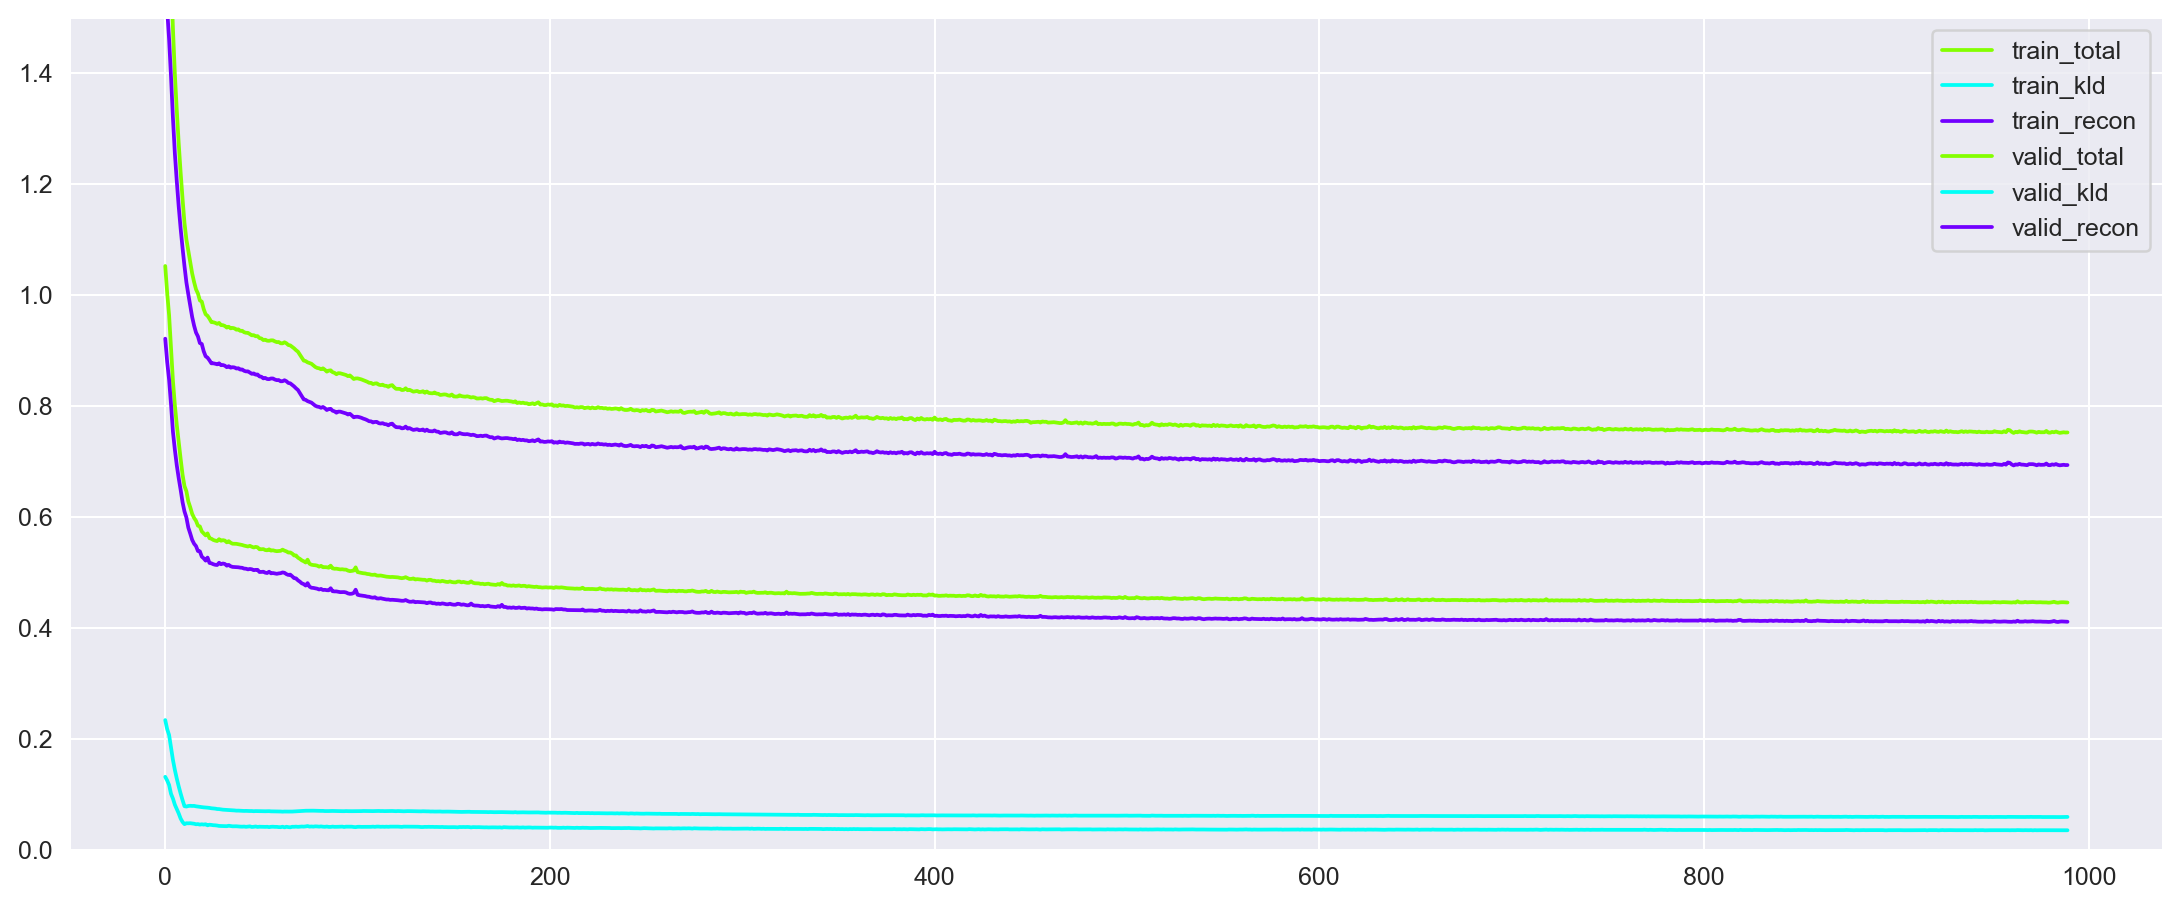

In [1312]:
model_concat_optim = FullFVAE(max_len=23, aa_dim= 20, use_v=use_v, use_j=use_j, v_dim=v_dim, j_dim=j_dim,
                 hidden_dim=256, latent_dim=128, activation = nn.SELU())

criterion = VAELoss(weight_seq=3, weight_kld=1.5, use_v=use_v, use_j=use_j, v_dim=v_dim, 
                    j_dim=j_dim,  weight_v=0.5, weight_j=0.3, debug=False)

optimizer = optim.Adam(model_concat_optim.parameters(), lr=1e-4, weight_decay=1e-2)
concat_train_losses, concat_valid_losses = [], []
concat_train_rec, concat_valid_rec = [], []
concat_train_kld, concat_valid_kld = [], []
for n in range(1000):
    acum_loss = 0
    acum_rec = 0
    acum_kld = 0
    # if n == 0 or n%10==0 :
    #     criterion.set_debug(True)
    # else:
    #     criterion.set_debug(False)

    # 230922 1322 : THIS RUN HAS THE ORIGINAL CONCATENATED DECODER (NOT SEPARATE FOR SEQ/V/J)
    for x, _  in train_loader:
        x_hat, mu, logvar = model_concat_optim(x)
        recon_loss, kld_loss = criterion(x_hat, x, mu, logvar)
        loss = recon_loss + kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acum_loss += loss.item() * y.shape[0]
        acum_rec += recon_loss.item() * y.shape[0]
        acum_kld += kld_loss.item() * y.shape[0]
    acum_loss /= len(train_loader.dataset)
    acum_rec /= len(train_loader.dataset)
    acum_kld /= len(train_loader.dataset)
    if n>=10:
        concat_train_rec.append(acum_rec)
        concat_train_kld.append(acum_kld)
        concat_train_losses.append(acum_loss)
    if n%10==0:
        criterion.set_debug(True)
        print(f'\n{n} epochs, Train Rec:\t{acum_rec:.3e}, KLD:\t{acum_kld:.3e}')
    else:
        criterion.set_debug(False)

    # Valid
    acum_loss = 0
    acum_rec = 0
    acum_kld = 0
    for x, _  in valid_loader:
        with torch.no_grad():
            x_hat, mu, logvar = model_concat_optim(x)
            recon_loss, kld_loss = criterion(x_hat, x, mu, logvar)
            loss = recon_loss + kld_loss        
            acum_loss += loss.item() * y.shape[0]
            acum_rec += recon_loss.item() * y.shape[0]
            acum_kld += kld_loss.item() * y.shape[0]
    acum_loss /= len(valid_loader.dataset)
    acum_rec /= len(valid_loader.dataset)
    acum_kld /= len(valid_loader.dataset)
    if n>=10:
        concat_valid_rec.append(acum_rec)
        concat_valid_kld.append(acum_kld)
        concat_valid_losses.append(acum_loss)
    if n%10==0:
        print(f'\n{n} epochs, Valid Rec:\t{acum_rec:.3e}, KLD:\t{acum_kld:.3e}')


In [ ]:
# Need to implement a scheduler or something or maybe split learning rates for kld and for reconstruction

## split optimizer


In [1326]:
from src.models import FullFVAE
from src.metrics import VAELoss

criterion = VAELoss(weight_seq=3, weight_kld=1.5, use_v=use_v, use_j=use_j, v_dim=v_dim, 
                    j_dim=j_dim,  weight_v=0.5, weight_j=0.3, debug=False)

model_split_optim = FullFVAE(max_len=max_len, aa_dim= 20, use_v=use_v, use_j=use_j, v_dim=v_dim, j_dim=j_dim,
                 hidden_dim=256, latent_dim=128, activation = nn.SELU())

optimizer_recon = optim.Adam(model_split_optim.parameters(), lr=5e-4, weight_decay=1e-4)
optimizer_kld = optim.Adam(model_split_optim.parameters(), lr=1e-7, weight_decay=1e-5)
split_train_losses, split_valid_losses = [], []
split_train_rec, split_valid_rec = [], []
split_train_kld, split_valid_kld = [], []
for n in range(1000):
    # Train
    acum_loss = 0
    acum_rec = 0
    acum_kld = 0
    for x, _  in train_loader:
        x_hat, mu, logvar = model_split_optim(x)
        recon_loss, kld_loss = criterion(x_hat, x, mu, logvar)
        loss = recon_loss + kld_loss
        optimizer_recon.zero_grad()
        optimizer_kld.zero_grad()
        loss.backward()
        optimizer_recon.step()
        optimizer_kld.step()
        
        acum_loss += loss.item() * y.shape[0]
        acum_rec += recon_loss.item() * y.shape[0]
        acum_kld += kld_loss.item() * y.shape[0]
    acum_loss /= len(train_loader.dataset)
    acum_rec /= len(train_loader.dataset)
    acum_kld /= len(train_loader.dataset)
    if n>=10:
        split_train_rec.append(acum_rec)
        split_train_kld.append(acum_kld)
        split_train_losses.append(acum_loss)
    if n%10==0:
        criterion.set_debug(True)
        print(f'\n{n} epochs, Train Rec:\t{acum_rec:.3e}, KLD:\t{acum_kld:.3e}')
    else:
        criterion.set_debug(False)

    # Valid
    acum_loss = 0
    acum_rec = 0
    acum_kld = 0
    for x, _  in valid_loader:
        with torch.no_grad():
            x_hat, mu, logvar = model_split_optim(x)
            recon_loss, kld_loss = criterion(x_hat, x, mu, logvar)
            loss = recon_loss + kld_loss        
            acum_loss += loss.item() * y.shape[0]
            acum_rec += recon_loss.item() * y.shape[0]
            acum_kld += kld_loss.item() * y.shape[0]
    acum_loss /= len(valid_loader.dataset)
    acum_rec /= len(valid_loader.dataset)
    acum_kld /= len(valid_loader.dataset)
    if n>=10:
        split_valid_rec.append(acum_rec)
        split_valid_kld.append(acum_kld)
        split_valid_losses.append(acum_loss)
    if n%10==0:
        print(f'\n{n} epochs, Valid Rec:\t{acum_rec:.3e}, KLD:\t{acum_kld:.3e}')

0.5660377358490566 0.09433962264150944 0.05660377358490566 0.2830188679245283

0 epochs, Train Rec:	1.010e+01, KLD:	1.277e-01
seq_loss tensor(6.1259)
v_loss tensor(0.0701)
j_loss tensor(0.2579)
kld_weight 0.2731132075471698
kld_loss tensor(0.3360) 

seq_loss tensor(6.3631)
v_loss tensor(0.0649)
j_loss tensor(0.2616)
kld_weight 0.2728301886792453
kld_loss tensor(0.3448) 

seq_loss tensor(6.2231)
v_loss tensor(0.0614)
j_loss tensor(0.2600)
kld_weight 0.27254716981132077
kld_loss tensor(0.3542) 

seq_loss tensor(6.4243)
v_loss tensor(0.0747)
j_loss tensor(0.2537)
kld_weight 0.27226415094339623
kld_loss tensor(0.3619) 

seq_loss tensor(6.4124)
v_loss tensor(0.0497)
j_loss tensor(0.2653)
kld_weight 0.2719811320754717
kld_loss tensor(0.3869) 


0 epochs, Valid Rec:	1.999e+00, KLD:	1.075e-01
seq_loss tensor(6.3786, grad_fn=<MulBackward0>)
v_loss tensor(0.0694, grad_fn=<MulBackward0>)
j_loss tensor(0.2133, grad_fn=<MulBackward0>)
kld_weight 0.27169811320754716
kld_loss tensor(0.3815, grad_fn=<

## Results

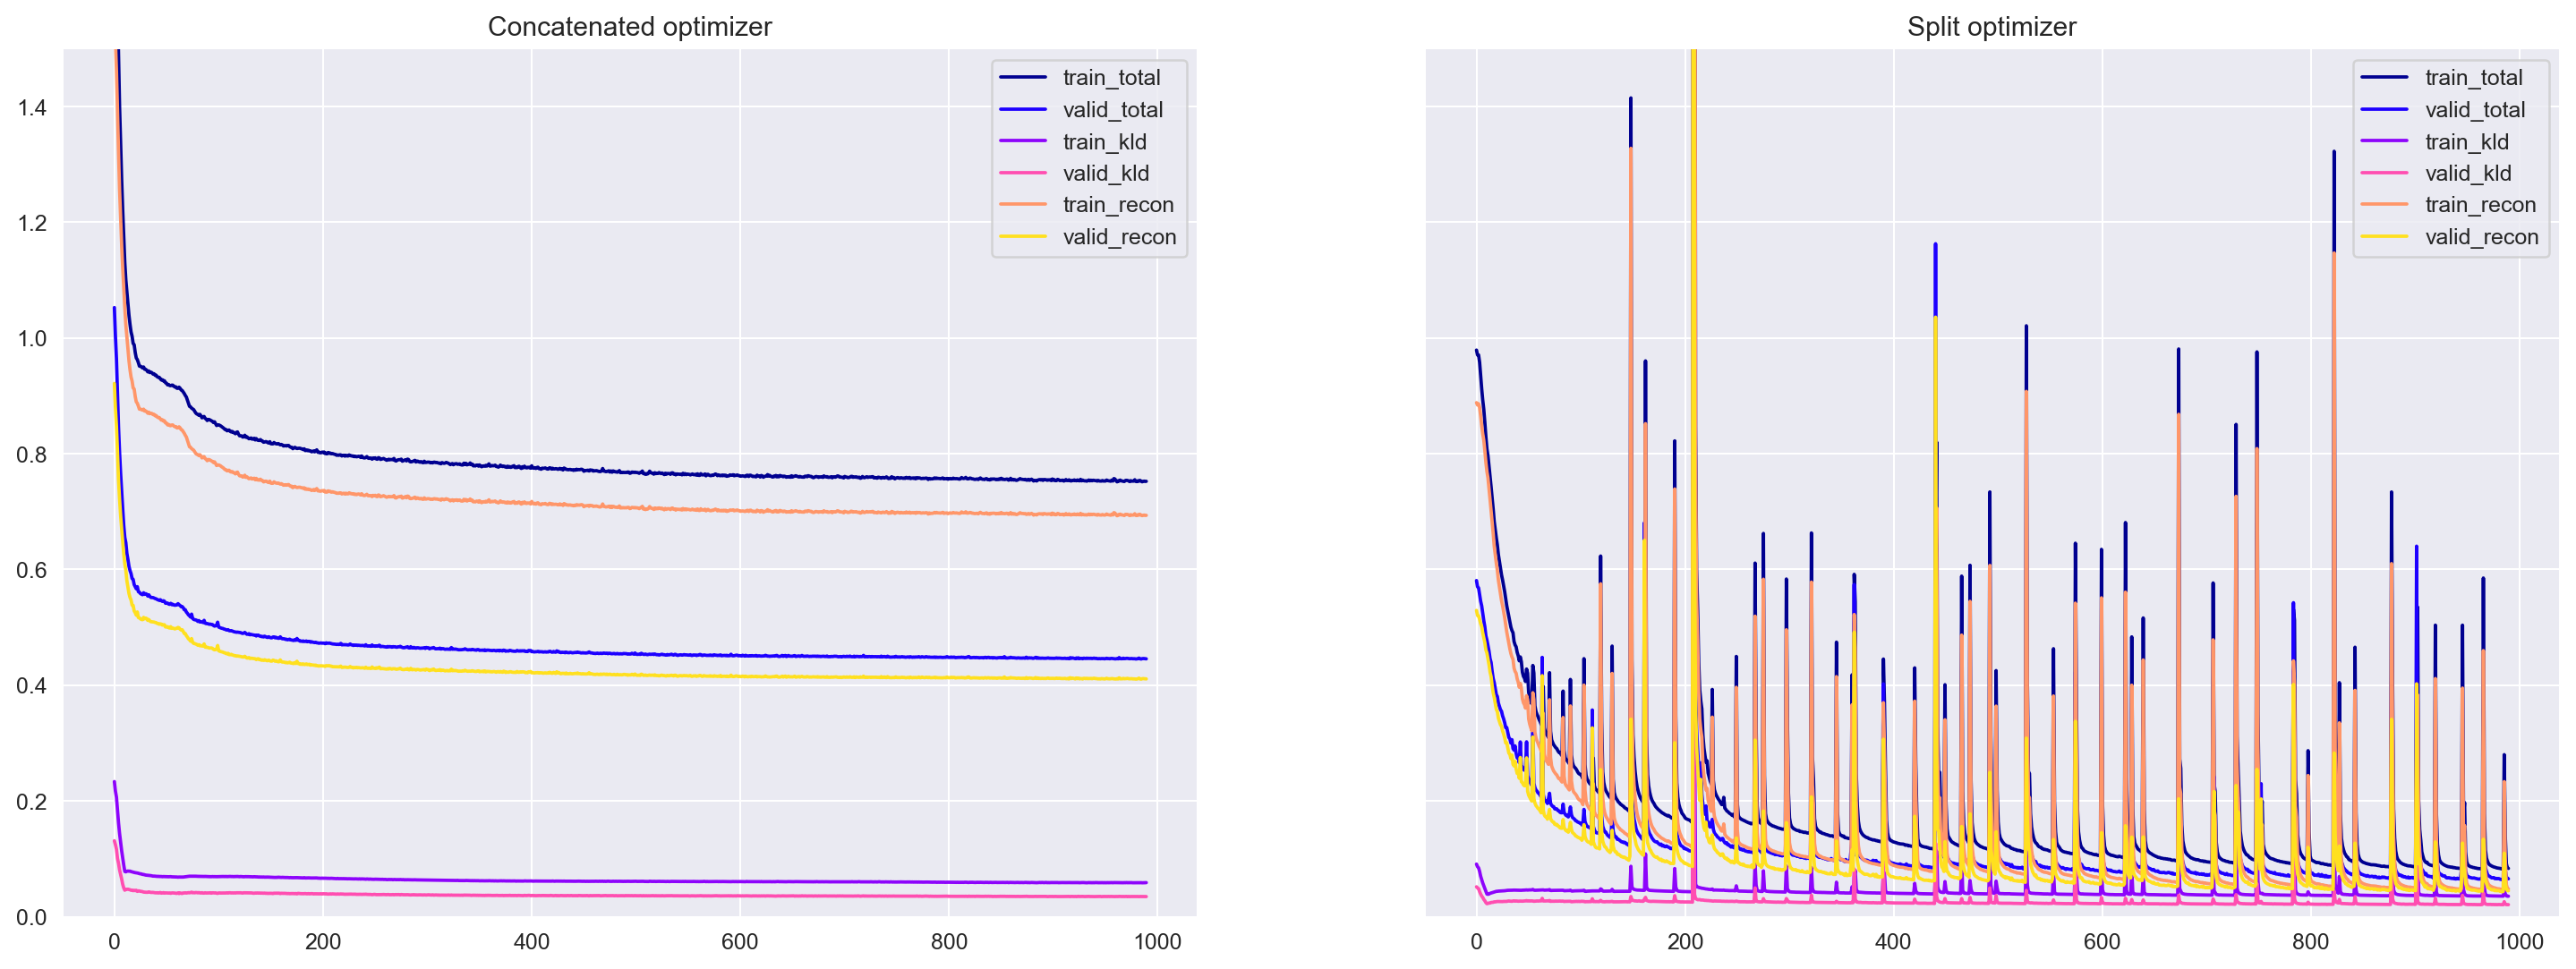

In [1327]:
sns.set_palette('gnuplot2', n_colors=6)
f,a = plt.subplots(1,2, figsize=(20,7), sharey=True)
a[0].set_title('Concatenated optimizer')
plt.ylim([0,1.5])
a[0].plot(range(len(concat_train_losses)), concat_train_losses, label='train_total')
a[0].plot(range(len(concat_train_losses)), concat_valid_losses, label='valid_total')
a[0].plot(range(len(concat_train_losses)), concat_train_kld, label='train_kld')
a[0].plot(range(len(concat_train_losses)), concat_valid_kld, label='valid_kld')
a[0].plot(range(len(concat_train_losses)), concat_train_rec, label='train_recon')
a[0].plot(range(len(concat_train_losses)), concat_valid_rec, label='valid_recon')
a[0].legend()

a[1].set_title('Split optimizer')
a[1].plot(range(len(split_train_losses)), split_train_losses, label='train_total')
a[1].plot(range(len(split_train_losses)), split_valid_losses, label='valid_total')
a[1].plot(range(len(split_train_losses)), split_train_kld, label='train_kld')
a[1].plot(range(len(split_train_losses)), split_valid_kld, label='valid_kld')
a[1].plot(range(len(split_train_losses)), split_train_rec, label='train_recon')
a[1].plot(range(len(split_train_losses)), split_valid_rec, label='valid_recon')
a[1].legend()

In [1343]:
print('Best concat_train_losses', round(min(concat_train_losses),4), f'Epoch = {concat_train_losses.index(min(concat_train_losses))}')
print('Best split_train_losses', round(min(split_train_losses),4), f'Epoch = {split_train_losses.index(min(split_train_losses))}')
print('\n','-'*100)
print('Best concat_valid_losses', round(min(concat_valid_losses),4), f'Epoch = {concat_valid_losses.index(min(concat_valid_losses))}')
print('Best split_valid_losses', round(min(split_valid_losses),4), f'Epoch = {split_valid_losses.index(min(split_valid_losses))}')
print('\n','-'*100)
print('Best concat_train_kld', round(min(concat_train_kld),4), f'Epoch = {concat_train_kld.index(min(concat_train_kld))}')
print('Best split_train_kld', round(min(split_train_kld),4), f'Epoch = {split_train_kld.index(min(split_train_kld))}')
print('\n','-'*100)
print('Best concat_valid_kld', round(min(concat_valid_kld),4), f'Epoch = {concat_valid_kld.index(min(concat_valid_kld))}')
print('Best split_valid_kld', round(min(split_valid_kld),4), f'Epoch = {split_valid_kld.index(min(split_valid_kld))}')
print('\n','-'*100)
print('Best concat_train_rec', round(min(concat_train_rec),4), f'Epoch = {concat_train_rec.index(min(concat_train_rec))}')
print('Best split_train_rec', round(min(split_train_rec),4), f'Epoch = {split_train_rec.index(min(split_train_rec))}')
print('\n','-'*100)
print('Best concat_valid_rec', round(min(concat_valid_rec),4), f'Epoch = {concat_valid_rec.index(min(concat_valid_rec))}')
print('Best split_valid_rec', round(min(split_valid_rec),4), f'Epoch = {split_valid_rec.index(min(split_valid_rec))}')

Best concat_train_losses 0.7514 Epoch = 961
Best split_train_losses 0.0819 Epoch = 984

 ----------------------------------------------------------------------------------------------------
Best concat_valid_losses 0.4452 Epoch = 984
Best split_valid_losses 0.0638 Epoch = 983

 ----------------------------------------------------------------------------------------------------
Best concat_train_kld 0.0585 Epoch = 986
Best split_train_kld 0.0354 Epoch = 989

 ----------------------------------------------------------------------------------------------------
Best concat_valid_kld 0.0345 Epoch = 971
Best split_valid_kld 0.0206 Epoch = 984

 ----------------------------------------------------------------------------------------------------
Best concat_train_rec 0.6928 Epoch = 961
Best split_train_rec 0.0464 Epoch = 984

 ----------------------------------------------------------------------------------------------------
Best concat_valid_rec 0.4104 Epoch = 984
Best split_valid_rec 0.043 

## Create fct to reconstruct / recover the closest BLOSUM encoding from the decoded sequences seq_hat

In [1434]:
print('v_true\t', v_true[:20].argmax(dim=1))
print('v_split\t', v_split[:20].argmax(dim=1))
print('v_cat\t', v_concat[:20].argmax(dim=1))

v_true	 tensor([31, 46, 46, 20, 45, 47, 20, 20, 22, 31])
v_split	 tensor([31, 39,  0, 20, 45, 47, 20, 20, 22, 31])
v_cat	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [1435]:
print('j_true\t', j_true[:20].argmax(dim=1))
print('j_split\t', j_split[:20].argmax(dim=1))
print('j_cat\t', j_concat[:20].argmax(dim=1))

j_true	 tensor([12, 12,  6,  1, 10,  7,  9,  3,  6, 12])
j_split	 tensor([12, 12,  6,  1, 10,  7,  9,  3,  6, 10])
j_cat	 tensor([12,  6, 12, 12,  6,  7, 12,  0,  6, 12])


In [1422]:
from src.models import FullFVAE
from src.data_processing import encoding_matrix_dict
from copy import deepcopy

pad_scale = -15
new_dict = deepcopy(encoding_matrix_dict['BL50LO'])
new_dict['X'] = np.array([pad_scale]).repeat(20)
NEW_KEYS = ''.join(new_dict.keys())
MATRIX_VALUES = torch.from_numpy(np.stack(list(new_dict.values())))
MATRIX_VALUES.shape
sample, _  = valid_dataset[:10]
# _, _ are mu, logvar
x_hat_split, _, _ = model_split_optim(sample)
x_hat_concat, _, _ = model_concat_optim(sample)

seq_true, v_true, j_true = model_split_optim.slice_x(sample)
seq_split, v_split, j_split = model_split_optim.slice_x(x_hat_split)
seq_concat, v_concat, j_concat = model_concat_optim.slice_x(x_hat_concat)

print('true\t', model_split_optim.recover_sequences_blosum(seq_true, MATRIX_VALUES, NEW_KEYS)[:3])
print('split\t', model_split_optim.recover_sequences_blosum(seq_split, MATRIX_VALUES, NEW_KEYS)[:3])
print('concat\t', model_split_optim.recover_sequences_blosum(seq_concat, MATRIX_VALUES, NEW_KEYS)[:3])


true	 ['ASSLAGGRYEQYXXXXXXXXXXX', 'ASTPPKRPRGEQYXXXXXXXXXX', 'ASSSITVDFYNEQFXXXXXXXXX']
split	 ['ASSLAGGRYEQYXXXXXXXXXTT', 'ASSPPKRPRGEQYXXXXXXXXTT', 'ASSSITVDFYNEQFXXXXXXXTT']
concat	 ['ASSLASSTHEQYXXXXXXXXXTT', 'ASSKAAAATNEQYXXXXXXXXTT', 'ASSKAASGAYNEQFXXXXXXXTT']


## Inference / clustering / latent visualisation

In [1445]:
x_valid = valid_dataset.x
df_valid = valid_dataset.df
labels = df_valid['peptide'].values

z_split = model_split_optim.embed(x_valid)
z_concat = model_concat_optim.embed(x_valid)